# Training models on SyntDataset
-----
Changing the model, we train different deep learning-based approaches.



In [1]:
# importing all the libraries needed
from SEDDOB import SyntDatasetModule
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime
import wandb
from modelsSED import *
from AuSPP import AuSPP


In [ ]:
# Read metadata
file_path = 'SimulatedBusDataset10class'
config = {
            "max_epochs": 50,
            "batch_size": 16,
            "lr": 0.001,
            "window_size": 512,
            "hop_size": 160,
            "mel_bins": 64,
            "frame_length": 0.02,
            "max_duration": 4,
            "num_classes": 10,
            "sr": 16000,
            "audio_samples": 10000,
}


# for each training 
for i in range(1,2): 
    n = datetime.now()
    n = n.strftime("%d-%m-%Y %H-%M-%S")
    wandb_logger = WandbLogger(project="SED", name = "WavegramLogMel SyntDataset {} Fold {}".format(n, i), tags = ['WavegramLogMel','10Classes-0.9-20ms'])
    # save hparms
    wandb_logger.log_hyperparams(config)
    list_folds = list(range(1,11))
    list_folds.remove(i) # First iteration has fold 1 as test, second iteration has fold 2 as test and so on..
    # define the Trainer with gpu
    trainer = Trainer(gpus = 1, log_every_n_steps = 25, max_epochs = config['max_epochs'], precision = 32, logger = wandb_logger)
    # define datamodule with i as the test fold
    data_module = SyntDatasetModule(file_path, list_folds,  [i], num_classes = config['num_classes'], batch_size = config['batch_size'], audio_samples = config['audio_samples'], frame_length = config['frame_length'])
    # initialization of the model using the pretrained weights
    model = AuSPP(sample_rate = config['sr'], window_size = config['window_size'], hop_size = config['hop_size'],
                            mel_bins = config['mel_bins'], fmin = 50, fmax = 8000, lr = config['lr'], max_duration = config['max_duration'],
                             num_classes = config['num_classes'], frame_length = config['frame_length'])
    print("Start Training on {} folds with test {}.".format(list_folds, i))
    wandb_logger.watch(model, log_graph=False)
    # start training the model on the training folds
    trainer.fit(model, datamodule = data_module)
    # models saves accuracy metrics
    logged_metrics = trainer.logged_metrics
    # val_accuracy.append(logged_metrics['val/acc_epoch'])
    wandb.finish()



# INFERENCE

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from AuSPP import AuSPP
import IPython

file_path = 'SimulatedBusDataset10class'
config = {
            "max_epochs": 50,
            "batch_size": 16,
            "lr": 0.001,
            "window_size": 512,
            "hop_size": 160,
            "mel_bins": 64,
            "frame_length": 0.02,
            "max_duration": 4,
            "num_classes": 10,
            "sr": 16000,
            "audio_samples": 10000,
}

label_list = ['breaking_glass', 'car_horn', 'gunshot', 'siren', 'slap', 'scream','cry','jackhammer','car_alarm','smoke_alarm']
duration = 4.0 # 4 seconds
frame_length = 0.02 # 50 ms
frames = int(duration/frame_length)
classes = len(label_list)

## DEMO InSecTT

In [72]:
id_file = np.random.randint(low = 1, high = 10000)
matrix_gt = np.zeros((classes, frames))
audio_path = os.path.join(file_path, "syntAudio", "fold{}".format( id_file // (10000 // 10) + 1), "{}.wav".format(id_file))
sound, _ = lb.load(audio_path, mono = True, sr = 16000, res_type = 'polyphase')
sound = sound.reshape(-1,1)   
model = AuSPP.load_from_checkpoint("AuSPP_trained_fold10.ckpt")
model.eval()
IPython.display.Audio(audio_path)

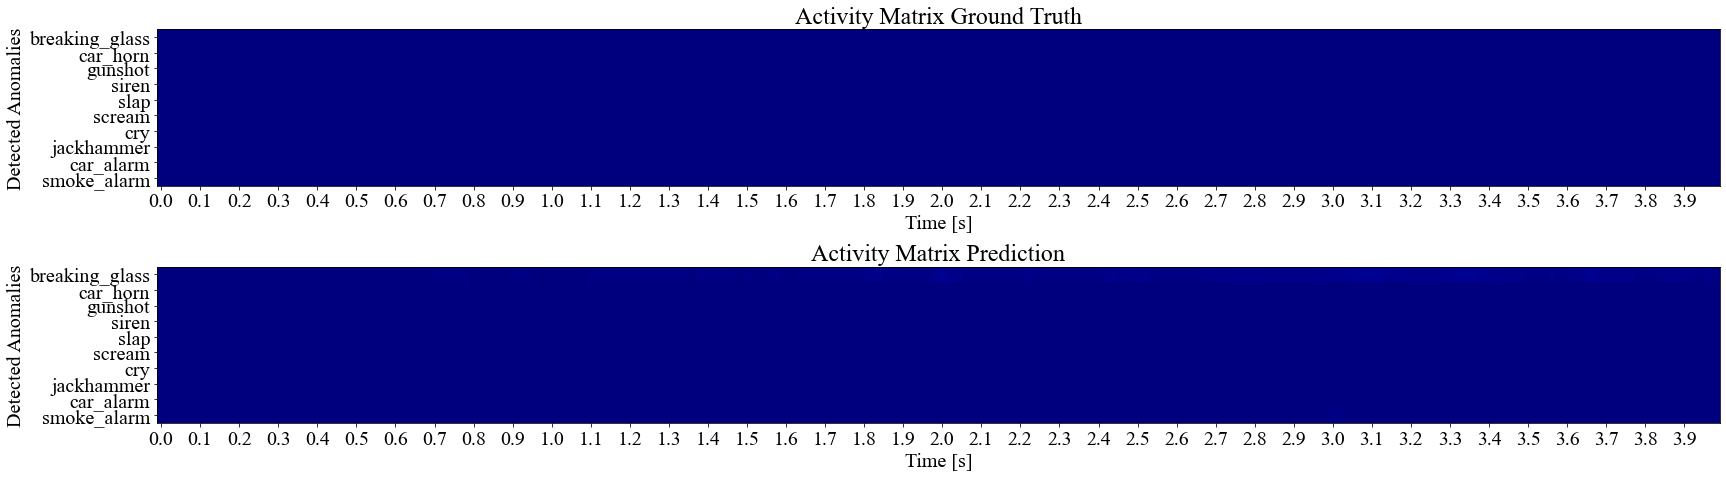

In [73]:
soundData = torch.tensor(sound.reshape(-1), dtype=torch.float).unsqueeze(0)
soundData = torch.cat((soundData, soundData))
with open(os.path.join(file_path, "labels", "fold{}".format(id_file // (10000 // 10) + 1),  "{}.txt".format(id_file)), "r") as file_in:
    for line in file_in:
        if line != "\n":
                line = line.split('\t')
                # read onset
                onset = np.float32(line[0])
                onset_frame = int(np.floor(onset/frame_length))
                offset = np.float32(line[1])
                offset_frame = int(np.ceil(offset/frame_length))
                class_id = line[2][:-1]
                # Mapping from class name and id
                if class_id == 'siren':
                    matrix_gt[3, onset_frame:offset_frame] = 1
                elif class_id == 'car_horn':
                    matrix_gt[1, onset_frame:offset_frame] = 1
                elif class_id == 'breaking_glass':
                    matrix_gt[0, onset_frame:offset_frame] = 1
                elif class_id == 'gunshot':
                    matrix_gt[2, onset_frame:offset_frame] = 1
                elif class_id == 'slap':
                    matrix_gt[4, onset_frame:offset_frame] = 1
                elif class_id == 'scream':
                    matrix_gt[5, onset_frame:offset_frame] = 1
                elif class_id == 'cry':
                    matrix_gt[6, onset_frame:offset_frame] = 1
                elif class_id == 'jackhammer':
                    matrix_gt[7, onset_frame:offset_frame] = 1
                elif class_id == 'car_alarm':
                    matrix_gt[8, onset_frame:offset_frame] = 1
                else:
                    matrix_gt[9, onset_frame:offset_frame] = 1

with torch.no_grad():
    test_loss = model(soundData)


stft = lb.feature.melspectrogram(y=soundData[0].numpy(), sr = 16000, n_fft=1024, 
        hop_length=320,  window='hann', center=True, n_mels = 64)
# Visualization of gt, prediction and melspectrogram
plt.rcParams.update({'font.family':'Times New Roman', 'font.size': 20})
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (28, 8))

axs[0].matshow(matrix_gt, cmap = "jet", vmin = 0, vmax = 1, aspect = 2)
axs[0].yaxis.set_ticks(np.arange(0, classes))
axs[0].yaxis.set_ticklabels(label_list)
axs[0].xaxis.set_ticks(np.arange(0, frames , 5))
axs[0].xaxis.set_ticklabels(np.round_(np.arange(0, frames, 5) * frame_length, decimals = 1))
axs[0].set_ylabel("Detected Anomalies")
axs[0].set_xlabel("Time [s]")
axs[0].set_title("Activity Matrix Ground Truth")
axs[0].xaxis.set_ticks_position('bottom')

axs[1].matshow(test_loss[0], cmap = "jet" , vmin = 0, vmax = 1, aspect = 2)
axs[1].yaxis.set_ticks(np.arange(0, classes))
axs[1].yaxis.set_ticklabels(label_list)
axs[1].xaxis.set_ticks(np.arange(0, frames , 5))
axs[1].xaxis.set_ticklabels(np.round_(np.arange(0, frames, 5) * frame_length, decimals = 1))
axs[1].set_ylabel("Detected Anomalies")
axs[1].set_xlabel("Time [s]")
axs[1].set_title("Activity Matrix Prediction")
axs[1].xaxis.set_ticks_position('bottom')


plt.savefig("pred_gt.pdf", format="pdf", bbox_inches="tight")